In [6]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt


from models.fullmodel import MultiViewCT
from models.unet2d import unet
from models.sampling import sample_features_single_view, coords_to_uv_for_angle
from utils.projection import render_drr_orthographic
from utils.volume_vis import show_triptych

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


net2d = unet().to(device)

model = MultiViewCT(
    unet_2d=net2d,
    Z=128, Y=128, X=128,
    feat_ch=128,
    pe_dim=9,
    inr_hidden=128,
    inr_blocks_view=3,
    inr_blocks_global=2,
    emb_dim=128,
    inr_out=1,
).to(device)

Z, Y, X = model.Z, model.Y, model.X
coords_all = model.coords.detach().cpu()  # (N,3)

In [7]:
print("coords shape:", coords_all.shape)
print("Z,Y,X:", Z, Y, X)
print("coords min/max:", coords_all.min().item(), coords_all.max().item())

coords shape: torch.Size([2097152, 3])
Z,Y,X: 128 128 128
coords min/max: -1.0 1.0


# Test linear indexing vs coordinates

Confirm that each coordinate maps to the correct flattened index

In [8]:
# Build the reference linear index (Z,Y,X)
idx_lin = torch.arange(Z*Y*X).view(Z, Y, X)

# Reconstruct indices from normalized coords
coords_min, coords_max = coords_all.min(), coords_all.max()

if coords_min >= -1.01 and coords_max <= 1.01:
    coords01 = (coords_all + 1) / 2.0
    zs = (coords01[:, 0] * (Z-1)).round().long()
    ys = (coords01[:, 1] * (Y-1)).round().long()
    xs = (coords01[:, 2] * (X-1)).round().long()
else:
    zs = coords_all[:, 0].round().long()
    ys = coords_all[:, 1].round().long()
    xs = coords_all[:, 2].round().long()

# Test a few sample indices
for k in [0, 1, 123456, Z*Y*X - 1]:
    z, y, x = zs[k].item(), ys[k].item(), xs[k].item()
    print(f"\nTest k = {k}")
    print("  coords[k] (z,y,x) ->", z, y, x)
    if 0 <= z < Z and 0 <= y < Y and 0 <= x < X:
        print("  idx_lin[z,y,x] =", idx_lin[z,y,x].item(), "(should be =", k, ")")
    else:
        print("  Warning: indices out of volume!")



Test k = 0
  coords[k] (z,y,x) -> 0 0 0
  idx_lin[z,y,x] = 0 (should be = 0 )

Test k = 1
  coords[k] (z,y,x) -> 0 0 1
  idx_lin[z,y,x] = 1 (should be = 1 )

Test k = 123456
  coords[k] (z,y,x) -> 7 68 64
  idx_lin[z,y,x] = 123456 (should be = 123456 )

Test k = 2097151
  coords[k] (z,y,x) -> 127 127 127
  idx_lin[z,y,x] = 2097151 (should be = 2097151 )


# Test UV projection at multiple angles

Verify rotation consistency by comparing u,v at 0 and π/2

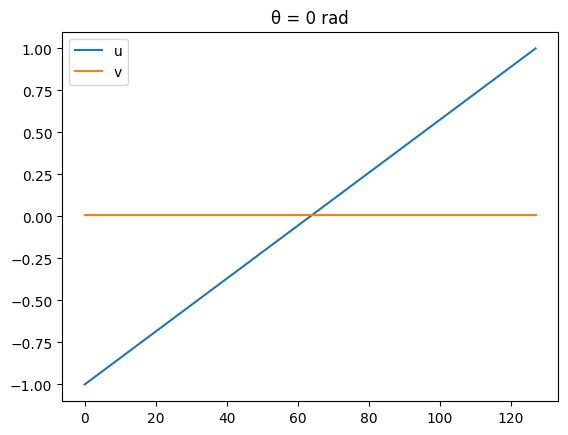

θ = 0 rad → u min/max: -1.0 1.0 v min/max: 0.007874019 0.007874019


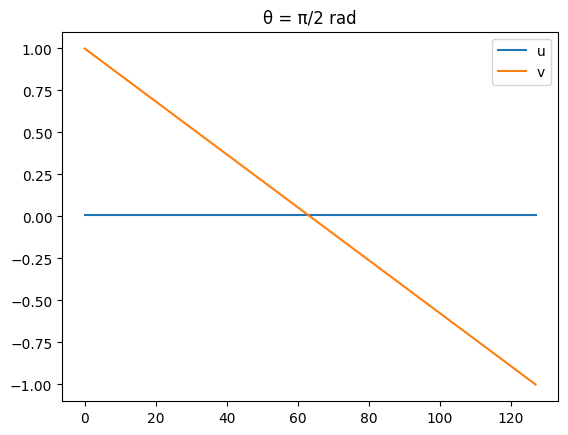

θ = π/2 rad → u min/max: 0.007873976 0.007874063 v min/max: -1.0 1.0


In [9]:
# Select one line at mid z,y
zs = torch.full((X,), Z//2, dtype=torch.long)
ys = torch.full((X,), Y//2, dtype=torch.long)
xs = torch.arange(X, dtype=torch.long)

indices = zs*Y*X + ys*X + xs
coords_line = coords_all[indices]   # (X,3)


def plot_uv(theta_rad, title):
    theta = torch.tensor(theta_rad)
    uv = coords_to_uv_for_angle(coords_line, theta)
    u = uv[:,0].numpy()
    v = uv[:,1].numpy()
    plt.figure()
    plt.plot(u, label="u")
    plt.plot(v, label="v")
    plt.legend()
    plt.title(title)
    plt.show()
    print(title, "→ u min/max:", u.min(), u.max(), "v min/max:", v.min(), v.max())

plot_uv(0.0, "θ = 0 rad")
plot_uv(np.pi/2, "θ = π/2 rad")

# Circular UV trajectory under rotation

Check that rotating a single voxel yields a circular path

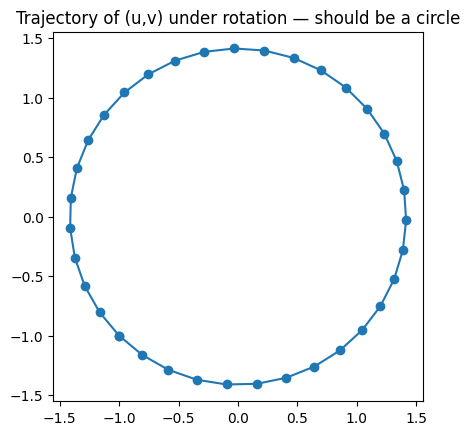

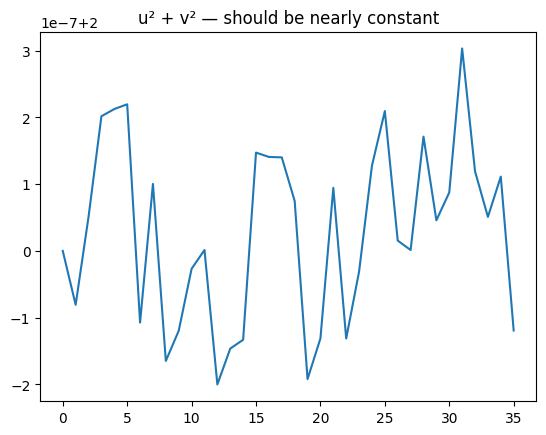

r^2 min/max: 1.9999997998980668 2.000000303226617


In [10]:
# pick a voxel
k = Z*Y*X//4
coords_k = coords_all[k:k+1]

us, vs = [], []
thetas = torch.linspace(0, 2*math.pi, 36)

for th in thetas:
    uv = coords_to_uv_for_angle(coords_k, th)
    us.append(uv[0,0].item())
    vs.append(uv[0,1].item())

us = np.array(us)
vs = np.array(vs)
r2 = us**2 + vs**2

plt.figure()
plt.plot(us, vs, 'o-')
plt.gca().set_aspect('equal', 'box')
plt.title("Trajectory of (u,v) under rotation — should be a circle")
plt.show()

plt.figure()
plt.plot(r2)
plt.title("u² + v² — should be nearly constant")
plt.show()

print("r^2 min/max:", r2.min(), r2.max())


# Test sampling on a horizontal gradient image

Validate sample_features_single_view() correctness

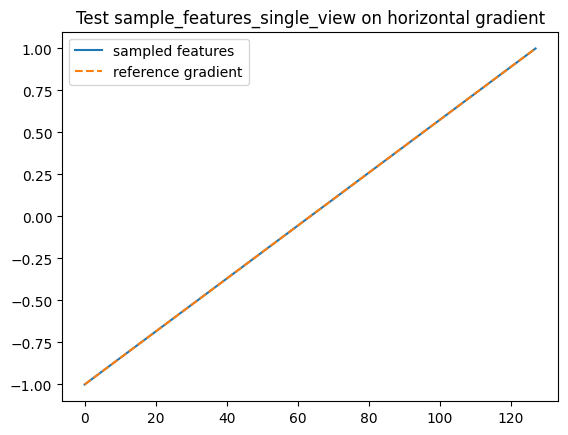

In [11]:
H = W = 128
B, C = 1, 1

x_coords = torch.linspace(-1, 1, W).view(1,1,1,W).expand(B,C,H,W)
Wi = x_coords.to(device)

coords_line_dev = model.coords[indices.to(device)]

theta = torch.tensor([0.0], device=device)

feat_line = sample_features_single_view(Wi, coords_line_dev, theta)
feat_line = feat_line[0,:,0].detach().cpu().numpy()

plt.figure()
plt.plot(feat_line, label="sampled features")
plt.plot(np.linspace(-1,1,X), '--', label="reference gradient")
plt.legend()
plt.title("Test sample_features_single_view on horizontal gradient")
plt.show()
